# Short WRF Tutorial for BNF

#### 2025 DOE ARM BNF Summer School
#### Created by: Tim Juliano, NSF NCAR

## The Weather Research and Forecasting, or WRF, model is a powerful tool to simulate atmospheric phenomena ranging from turbulent microscale fronts to synoptic-scale hurricanes. WRF is used widely in the atmospheric science community, and more information about the model can be found [here](https://opensky.ucar.edu/islandora/object/technotes%3A588). 

## In this tutorial, we'll focus on a shallow convection case that occurred on April 11th, 2025. The main goals are for you to learn how to:
1. Read WRF output files
2. Extract model information for grid cells nearest to our ARM BNF sites
3. Make time series, planview, and cross-section plots

## Import libraries

In [13]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from scipy.spatial import cKDTree
import pandas as pd
from wrf import (getvar, CoordPair, vertcross, latlon_coords, to_np, destagger)
import glob
from netCDF4 import Dataset

# Set paths to model outputs

In [14]:
path_head = '/glade/derecho/scratch/tjuliano/doe_seus/WRF-MCANOPY-ASR/WRFV4.5.2/test/BNF_2025SS/'
case_day = '2025041106/'

# Open files, load into dataset, and inspect

In [15]:
ds_wrf = xr.open_mfdataset(os.path.join(path_head+case_day+'run/wrfout_d01*'),concat_dim='Time',combine='nested')
ds_wrf

<xarray.Dataset>
Dimensions:                (Time: 97, south_north: 1000, west_east: 1000, bottom_top: 102, bottom_top_stag: 103, soil_layers_stag: 10, west_east_stag: 1001, south_north_stag: 1001, pft_fraction_stag: 17, seed_dim_stag: 2, subgrid_stag: 10)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1000, 1001), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 dask.array<chunksize=(1, 1000, 1001), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1001, 1000), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 dask.array<chunksize=(1, 1001, 1000), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag, pft_fraction_stag, seed_dim_stag, subgrid_stag
Data variables: (12/246)
    Times                  (Time) |S19 dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 dask.array<chunksize=(1, 102), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 dask.array<chunksize=(1, 103), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 10), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 dask.array<chunksize=(1, 10), meta=np.ndarray>
    ...                     ...
    PERT_T                 (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(1, 102, 1000, 1000), meta=np.ndarray>
    M_PBLH                 (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    LANDMASK               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    LAKEMASK               (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    SST                    (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    SST_INPUT              (Time, south_north, west_east) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.5.2 MODEL
    START_DATE:                      2025-04-11_06:00:00
    SIMULATION_START_DATE:           2025-04-11_06:00:00
    WEST-EAST_GRID_DIMENSION:        1001
    SOUTH-NORTH_GRID_DIMENSION:      1001
    BOTTOM-TOP_GRID_DIMENSION:       103
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

# Create a dictionary for our ARM sites so we can easily find them in the model

In [16]:
# Pull static lat/lon at first time step
lat2d = ds_wrf['XLAT'].isel(Time=0)
lon2d = ds_wrf['XLONG'].isel(Time=0)

# Flatten and build KDTree
flat_coords = np.column_stack((lat2d.values.ravel(), lon2d.values.ravel()))
tree = cKDTree(flat_coords)

# ARM site locations
target_lat = [34.3425, 34.6538, 34.3848, 34.1788]
target_lon = [-87.3382, -87.2927, -86.9279, -87.4539]
target_coords = np.column_stack((target_lat, target_lon))

# Find nearest indices
_, flat_idx = tree.query(target_coords)
i_indices, j_indices = np.unravel_index(flat_idx, lat2d.shape)

# Create dict of site names to datasets
site_names = ['M1', 'S20', 'S30', 'S40']
site_datasets = {}

for name, i, j in zip(site_names, i_indices, j_indices):
    site_datasets[name] = ds_wrf.isel(south_north=i, west_east=j).expand_dims(site=[name])

# Subset the original WRF dataset so that it includes information for just our sites

In [17]:
ds_wrf_bnf_site = xr.concat(site_datasets.values(), dim='site')
ds_wrf_bnf_site

<xarray.Dataset>
Dimensions:                (site: 4, Time: 97, bottom_top: 102, bottom_top_stag: 103, soil_layers_stag: 10, west_east_stag: 1001, south_north_stag: 1001, pft_fraction_stag: 17, seed_dim_stag: 2, subgrid_stag: 10)
Coordinates:
  * site                   (site) <U3 'M1' 'S20' 'S30' 'S40'
    XLAT                   (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    XLONG                  (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                 (site, Time, west_east_stag) float32 dask.array<chunksize=(1, 1, 1001), meta=np.ndarray>
    XLONG_U                (site, Time, west_east_stag) float32 dask.array<chunksize=(1, 1, 1001), meta=np.ndarray>
    XLAT_V                 (site, Time, south_north_stag) float32 dask.array<chunksize=(1, 1, 1001), meta=np.ndarray>
    XLONG_V                (site, Time, south_north_stag) float32 dask.array<chunksize=(1, 1, 1001), meta=np.ndarray>
Dimensions without coordinates: Time, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag, pft_fraction_stag, seed_dim_stag, subgrid_stag
Data variables: (12/246)
    Times                  (site, Time) |S19 dask.array<chunksize=(1, 1), meta=np.ndarray>
    LU_INDEX               (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ZNU                    (site, Time, bottom_top) float32 dask.array<chunksize=(1, 1, 102), meta=np.ndarray>
    ZNW                    (site, Time, bottom_top_stag) float32 dask.array<chunksize=(1, 1, 103), meta=np.ndarray>
    ZS                     (site, Time, soil_layers_stag) float32 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    DZS                    (site, Time, soil_layers_stag) float32 dask.array<chunksize=(1, 1, 10), meta=np.ndarray>
    ...                     ...
    PERT_T                 (site, Time, bottom_top) float32 dask.array<chunksize=(1, 1, 102), meta=np.ndarray>
    M_PBLH                 (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    LANDMASK               (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    LAKEMASK               (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SST                    (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    SST_INPUT              (site, Time) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.5.2 MODEL
    START_DATE:                      2025-04-11_06:00:00
    SIMULATION_START_DATE:           2025-04-11_06:00:00
    WEST-EAST_GRID_DIMENSION:        1001
    SOUTH-NORTH_GRID_DIMENSION:      1001
    BOTTOM-TOP_GRID_DIMENSION:       103
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      0
    ETAC:                            0.0

# Now let's make some plots!
## First, time series plots comparing the different sites

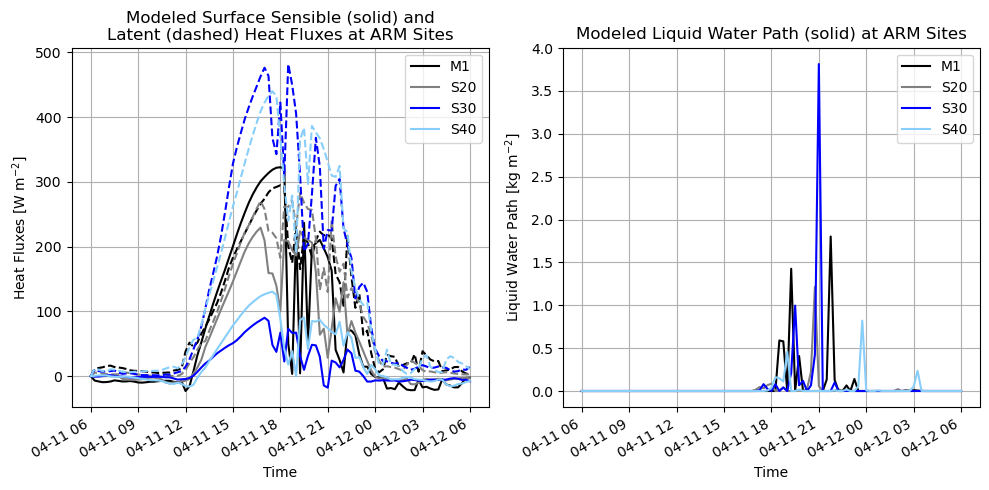

In [18]:
# Select the variables you want to plot
var1a = ds_wrf_bnf_site['HFX'] # surface sensible heat flux
var1b = ds_wrf_bnf_site['LH'] # surface latent heat flux

var2 = ds_wrf_bnf_site['LWP'] # liquid water path

# Make the plot
plt.figure(figsize=(10, 5))
cols = ['k','gray','b','lightskyblue']

######################## Subplot 1 ########################
# Sensible and latent heat fluxes
plt.subplot(1,2,1)
count = 0
for site in var1a.site.values:
    plt.plot(var1a['XTIME'], var1a.sel(site=site), c=cols[count], label=site)
    plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
    count+=1

plt.xlabel("Time")
plt.ylabel("Heat Fluxes [W m$^{-2}$]")
plt.title("Modeled Surface Sensible (solid) and\nLatent (dashed) Heat Fluxes at ARM Sites")
plt.legend()
plt.grid(True)


######################## Subplot 2 ########################
# Liquid water path
plt.subplot(1,2,2)
count = 0
for site in var2.site.values:
    plt.plot(var2['XTIME'], var2.sel(site=site), c=cols[count], label=site)
    #plt.plot(var1b['XTIME'], var1b.sel(site=site), c=cols[count], ls='--')
    
    count+=1

plt.xlabel("Time")
plt.ylabel("Liquid Water Path [kg m$^{-2}$]")
plt.title("Modeled Liquid Water Path (solid) at ARM Sites")
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate() # clean up labels


plt.tight_layout()
plt.show()

## Now let's make a planview (x-y) plot showing sensible heat fluxes and liquid water path

Making plot for 2025-04-11 17:15


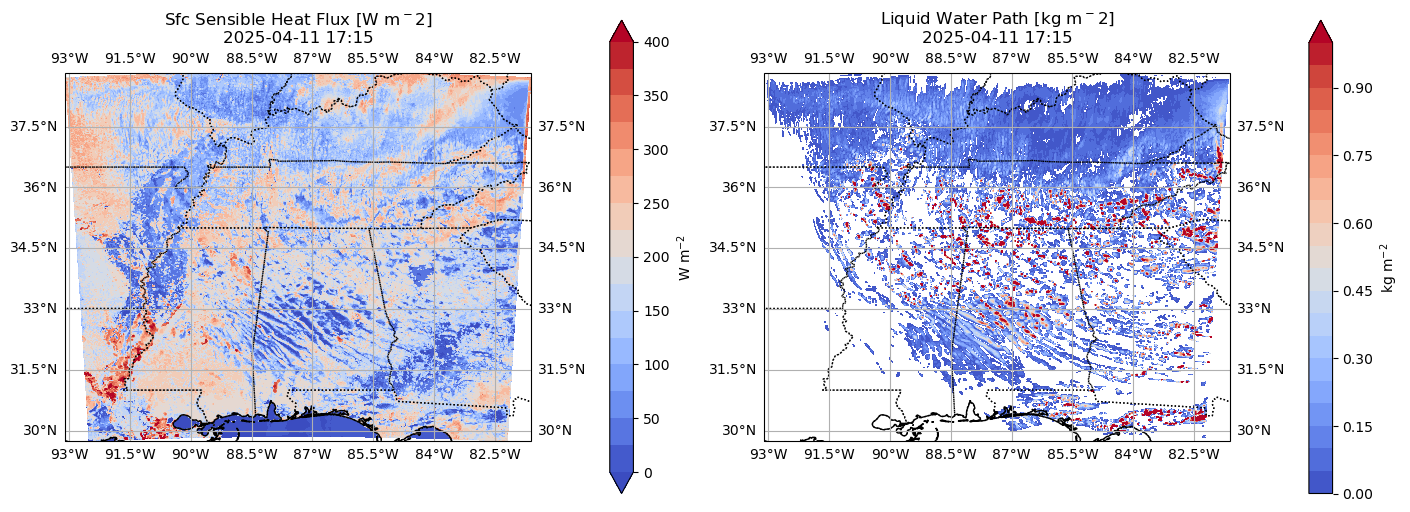

In [19]:
# Pick a time
tidx = 60
time = ds_wrf['XTIME'].isel(Time=45).values
time_cleaned = np.datetime_as_string(time, unit='m').replace('T', ' ')
print ('Making plot for ' + str(time_cleaned))

# Set up panel plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

######################## Subplot 1 ########################
# Sensible heat flux
cf_var = ds_wrf['HFX'].isel(Time=tidx)
rng1 = np.arange(0,425,25)
cf1 = axs[0].contourf(lon2d, lat2d, cf_var, rng1, cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), extend='both')
axs[0].set_title(f'Sfc Sensible Heat Flux [W m$^{-2}$]\n{time_cleaned}')
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.BORDERS, linestyle=':')
axs[0].add_feature(cfeature.STATES, linestyle=':')
axs[0].gridlines(draw_labels=True)
fig.colorbar(cf1, ax=axs[0], orientation='vertical', shrink=0.8, label='W m$^{-2}$')


######################## Subplot 2 ########################
# Latent heat flux
cf_var = ds_wrf['LWP'].isel(Time=tidx)
cf_var = cf_var.where(cf_var >= 0.01) # set a threshold of 10 g/m2
rng2 = np.arange(0,1.05,0.05)
cf2 = axs[1].contourf(lon2d, lat2d, cf_var, rng2, cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), extend='max')
axs[1].set_title(f'Liquid Water Path [kg m$^{-2}$]\n{time_cleaned}')
axs[1].add_feature(cfeature.COASTLINE)
axs[1].add_feature(cfeature.BORDERS, linestyle=':')
axs[1].add_feature(cfeature.STATES, linestyle=':')
axs[1].gridlines(draw_labels=True)
fig.colorbar(cf2, ax=axs[1], orientation='vertical', shrink=0.8, label='kg m$^{-2}$')

## How about a nifty cross-section between S20 and S40
### Note: we're using the wrf-python package, but newer and less clunky packages exist

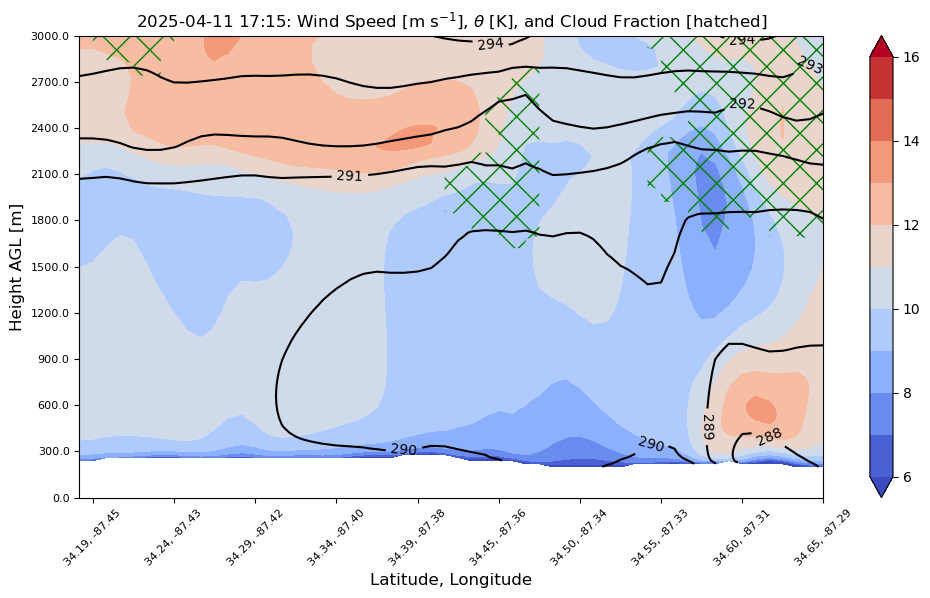

In [20]:
wrf_files = sorted(glob.glob(path_head+case_day+'run/wrfout_d01*'))

ncfile = Dataset(wrf_files[tidx])

# Select variables
z = getvar(ncfile, "z") # height AGL
wspd = getvar(ncfile, "uvmet_wspd_wdir")[0,:] # wind speed
th =  getvar(ncfile, "theta", units='K') # theta
cloudfrac =  getvar(ncfile, "CLDFRA") # cloud fraction

# Define cross-section endpoints (lat, lon)
# Let's go from S20 (start point) to S40 (end point)
start_point = CoordPair(lat=target_lat[1], lon=target_lon[1])
end_point = CoordPair(lat=target_lat[3], lon=target_lon[3])

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section.
levs = np.arange(0,3020,20)
wspd_cross = vertcross(wspd, z, levels=levs, wrfin=ncfile, start_point=start_point, end_point=end_point,
                       latlon=True, meta=True)
th_cross = vertcross(th, z, levels=levs, wrfin=ncfile, start_point=start_point, end_point=end_point,
                       latlon=True, meta=True)
cloudfrac_cross = vertcross(cloudfrac, z, levels=levs, wrfin=ncfile, start_point=start_point, end_point=end_point,
                       latlon=True, meta=False)

# Create the figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

# Make the contour plot
wspd_contours = ax.contourf(to_np(wspd_cross),levels=np.arange(6,17,1),cmap=plt.cm.coolwarm,extend='both')

# Add the color bar
plt.colorbar(wspd_contours, ax=ax)

cloudfrac_cross[cloudfrac_cross<=0.0] = np.nan
masked_cldfra = np.ma.masked_less(cloudfrac_cross, 0.0)
plt.rcParams['hatch.color'] = 'green'
plt.contourf(to_np(masked_cldfra), hatches='X', alpha=0.)

th_contours = ax.contour(to_np(th_cross),levels=np.arange(250,341,1),colors='k')
plt.clabel(th_contours)

xtick_skip = 6
ytick_skip = 15

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(th_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::xtick_skip])
ax.set_xticklabels(x_labels[::xtick_skip], rotation=45, fontsize=8)

# Set the y-ticks to be height
vert_vals = to_np(th_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::ytick_skip])
ax.set_yticklabels(vert_vals[::ytick_skip], fontsize=8)

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height AGL [m]", fontsize=12)

plt.title(time_cleaned + r": Wind Speed [m s$^{-1}$], $\theta$ [K], and Cloud Fraction [hatched]")

plt.gca().invert_xaxis()